In [2]:
# -*- coding: utf-8 -*-
import numpy as np
import platform
import tempfile
import os
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
# necessite scikit-image
from skimage import io as skio
import tempfile
import IPython
# POUR LA MORPHO
#from skimage.morphology import watershed
from skimage.feature import peak_local_max



In [3]:
#%%
# VOUS DEVEZ FIXER LES DEUX VARIABLES SUIVANTES:
colaboratory=True #mettre True si vous utilisez google colab
notebook=False   # mettre Trus si vous utilisez un notebook local
# les seuls couples possibles sont (False,False)= travailler localement sans notebook
# (False,True): jupyternotebook local
# (True, False): google colab


assert (not (colaboratory and notebook)), "Erreur, choisissez google colab ou notebook local mais pas les deux en meme temps"

if colaboratory: #Si google colab on installe certaines librairies
    !pip install soundfile
    from IPython.display import Audio
    !pip install bokeh
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()
    !wget https://perso.telecom-paristech.fr/ladjal/donnees_IMA203.tgz
    !tar xvzf donnees_IMA203.tgz
    os.chdir('donnees_IMA203')

if notebook: # si notebook normal dans une machine locale vous devez installer bokeh vous-meme
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()






--2024-01-25 19:01:36--  https://perso.telecom-paristech.fr/ladjal/donnees_IMA203.tgz
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 290918 (284K) [application/x-gzip]
Saving to: ‘donnees_IMA203.tgz’

donnees_IMA203.tgz  100%[===================>] 284.10K  1.02MB/s    in 0.3s    

2024-01-25 19:01:37 (1.02 MB/s) - ‘donnees_IMA203.tgz’ saved [290918/290918]

donnees_IMA203/
donnees_IMA203/lacornou.tif
donnees_IMA203/lena.tif


In [4]:
#%% fonction pour voir une image
#FONCTION viewimage universelle
def viewimage_universelle(im, normalize=True,titre='',displayfilename=False):
    imin=im.copy().astype(np.float32)
    if normalize:
      imin-=imin.min()
    if imin.max()>0:
      imin/=imin.max()
    else:
      imin=imin.clip(0,255)/255
      imin=(imin*255).astype(np.uint8)
    filename=tempfile.mktemp(titre+'.png')
    if displayfilename:
      print (filename)
    plt.imsave(filename, imin, cmap='gray')
    IPython.display.display(IPython.display.Image(filename))



def viewimage(im,normalise=True,MINI=0.0, MAXI=255.0,titre=''):
    """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI et MAXI seront mis a 0 et 255 dans l'image resultat

    """
    imt=np.float32(im.copy())
    if platform.system()=='Darwin': #on est sous mac
        prephrase='open -a /Applications/GIMP.app '
        endphrase=' &'
    elif platform.system()=='Linux': #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais comment faire. Si vous savez dites-moi.)
        prephrase='gimp -a '
        endphrase= ' &'
    elif platform.system()=='Windows':
        prephrase='start /B "D:/GIMP/bin/gimp-2.10.exe" -a '#Remplacer D:/... par le chemin de votre GIMP
        endphrase= ''
    else:
        print('Systeme non pris en charge par l affichage GIMP')
        return 'erreur d afficahge'

    if normalise:
        m=imt.min()
        imt=imt-m
        M=imt.max()
        if M>0:
            imt=imt/M

    else:
        imt=(imt-MINI)/(MAXI-MINI)
        imt[imt<0]=0
        imt[imt>1]=1

    if titre!='':
        titre='_'+titre+'_'
    nomfichier=tempfile.mktemp('TPIMA'+titre+'.png')
    commande=prephrase +nomfichier+endphrase
    skio.imsave(nomfichier,imt)
    os.system(commande)

#si on est dans un notebook (y compris dans colab), on utilise bokeh pour visualiser

usebokeh= colaboratory or notebook
if usebokeh:
    def normalise_image_pour_bokeh(X,normalise,MINI,MAXI):
        imt=np.copy(X.copy())
        if normalise:
            m=imt.min()
            imt=imt-m
            M=imt.max()
            if M>0:
                imt=imt/M

        else:

            imt=(imt-MINI)/(MAXI-MINI)
            imt[imt<0]=0
            imt[imt>1]=1
        imt*=255

        sortie=np.empty((*imt.shape,4),dtype=np.uint8)
        for k in range(3):
            sortie[:,:,k]=imt
        sortie[:,:,3]=255
        return sortie
    def viewimage(im,normalise=True,MINI=0.0, MAXI=255.0,titre=''):

        img=normalise_image_pour_bokeh(np.flipud(im),normalise,MINI,MAXI)# np.flipud(np.fliplr(im)))
        p = figure(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")],title=titre)
        p.x_range.range_padding = p.y_range.range_padding = 0

        # must give a vector of images
        p.image_rgba(image=[img], x=0,y=0, dw=im.shape[1], dh=im.shape[0])
        showbokeh(p)




In [5]:
#%% fonctions utiles au TP

def appfiltre(u,K):
    """ applique un filtre lineaire (en utilisant une multiplication en Fourier) """

    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    out=np.real(ifft2(fft2(u)*fft2(K)))
    return out

def degrade_image(im,br):
    """degrade une image en lui ajoutant du bruit"""
    out=im+br*np.random.randn(*im.shape)
    return out

def  grady(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient en bas est nul"""

    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:-1,:]=-I[:-1,:]+I[1:,:]
    M[-1,:]=np.zeros((n,))
    return M

def  gradx(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient a droite est nul"""

    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:,:-1]=-I[:,:-1]+I[:,1:]
    M[:,-1]=np.zeros((m,))
    return M

def div(px,py):
    """calcule la divergence d'un champ de gradient"""
    """ div= - (grad)^*, i.e. div est la transposee de l'operateur gradient"""
    (m,n)=px.shape
    assert px.shape==py.shape , " px et py n'ont pas la meme taille dans div"
    Mx=np.zeros((m,n))
    My=np.zeros((m,n))

    My[1:-1,:]=py[1:-1,:]-py[:-2,:]
    My[0,:]=py[0,:]
    My[-1,:]=-py[-2,:]

    Mx[:,1:-1]=px[:,1:-1]-px[:,:-2]
    Mx[:,0]=px[:,0]
    Mx[:,-1]=-px[:,-2]
    return Mx+My

def gradient_TV(v,u,lamb):
    """ calcule le gradient de la fonctionnelle E2 du TP"""
# on n'utilise pas gradx et grady car pour minimiser
# la fonctionnelle E2 par descente de gradient nous avons choisi
# de prendre les memes conditions au bords que pour la resolution quadratique
    (sy,sx)=v.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Kxback=np.zeros((sy,sx))
    Kyback=np.zeros((sy,sx))
    Kxback[0,0]=-1
    Kxback[0,-1]=1
    Kyback[0,0]=-1
    Kyback[-1,0]=1

    Dx=appfiltre(u,Kx)
    Dy=appfiltre(u,Ky)
    ng=(Dx**2+Dy**2)**0.5+1e-5
    div=appfiltre(Dx/ng,Kxback)+appfiltre(Dy/ng,Kyback)
    return 2*(u-v)-lamb*div

def gradient_TV_nonperiodique(v,u,lamb):
     """ calcule le gradient de la fonctionnelle E2 du TP"""
     gx=gradx(u)
     gy=grady(u)
     ng=((gx**2)+(gy**2))**0.5+1e-5
     dive=div(gx/ng,gy/ng)
     return 2*(u-v)-lamb*dive


def resoud_quad_fourier(K,V):
    """trouve une image im qui minimise sum_i || K_i conv im - V_i||^2
     ou les K_i et les Vi sont des filtres et des images respectivement """

    n=len(K)
    assert len(K) == len(V) , "probleme de nombre de composantes dans resoud_quad"
    (sy,sx)=K[0].shape
    numer=np.vectorize(np.complex)(np.zeros((sy,sx)))
    denom=np.vectorize(np.complex)(np.zeros((sy,sx)))
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    for k in range(n):
        fV=fft2(V[k])
        fK=fft2(K[k])
        #print('type de fV',fV.dtype,' type de fK',fK.dtype)
        numer+=np.conj(fK)*fV
        denom+=abs(fK)**2
    return np.real(ifft2(numer/denom))

def minimisation_quadratique(v,lamb):
    """ minimise la fonctionnelle E1 du TP"""
    (sy,sx)=v.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    delta=np.zeros((sy,sx))
    delta[0,0]=1.0
    s=lamb**0.5
    K=(s*Kx,s*Ky,delta)
    V=(np.zeros((sy,sx)),np.zeros((sy,sx)),v)
    return resoud_quad_fourier(K,V)

def norme_VT(I):
    """ renvoie la norme de variation totale de I"""
    (sy,sx)=I.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Dx=appfiltre(I,Kx)
    Dy=appfiltre(I,Ky)
    ng=(Dx**2+Dy**2)**0.5
    return ng.sum()

def norme_VT_nonperiodique(u):
    gx=gradx(u)
    gy=grady(u)
    ng=((gx**2)+(gy**2))**0.5
    return ng.sum()

def norm2(x):
    return ((x**2).sum())**0.5

def E2_nonperiodique(u,v,lamb): # renvoie l'énergie E2
    return lamb*norme_VT_nonperiodique(u)+norm2(u-v)**2


def minimise_TV_gradient(v,lamb,pas,nbpas):
    """ minimise E2 par descente de gradient a pas constant """
    u=np.zeros(v.shape)
    Energ=np.zeros(nbpas)
    for k in range(nbpas):
        #print(k)
        Energ[k]=E2_nonperiodique(u,v,lamb)
        u=u-pas*gradient_TV_nonperiodique(v,u,lamb)
    return (u,Energ)


def projection(I,a,itmax):
    """ calcule la projection de I sur G_a
        G_a est le sous-gradient de TV en zero
        Comme vu dans le poly cette projection permet de resoudre le probleme
        de debruitage TV (E2)"""
    # ici on utilise les conditions au bord de von neuman
    # i.e. on utilise gradx et grady definis plus haut et non pas une convolution circulaire
    (m,n)=I.shape
    t=0.1249
    px=np.zeros((m,n))
    py=np.zeros((m,n))
    un=np.ones((m,n))

    for it in range(itmax):
        N=div(px,py)-I/a
        Gx=gradx(N)
        Gy=grady(N)
        G=(Gx**2+Gy**2)**0.5
        pxnew=(px+t*Gx)/(un+t*G)
        pynew=(py+t*Gy)/(un+t*G)
        px=pxnew
        py=pynew
    # la projection est la divergence du champ px,py
    P=a*div(px,py)
    return P

def vartotale_Chambolle(v,lamb,itmax=100):
    """ Trouve une image qui minimise lamb*TV(I)+||I-v||^2
    en utilisant la projection dur G_a"""
    (m,n)=v.shape
    P=projection(v,lamb/2,itmax)
    return v-P


def imread(fichier):
    return np.float32(skio.imread(fichier))


In [6]:
#%% lire une image

im=imread('lena.tif') #ATTENTION IL FAUT ETRE DANS LE BON REPERTOIRE (utiliser os.chdir())



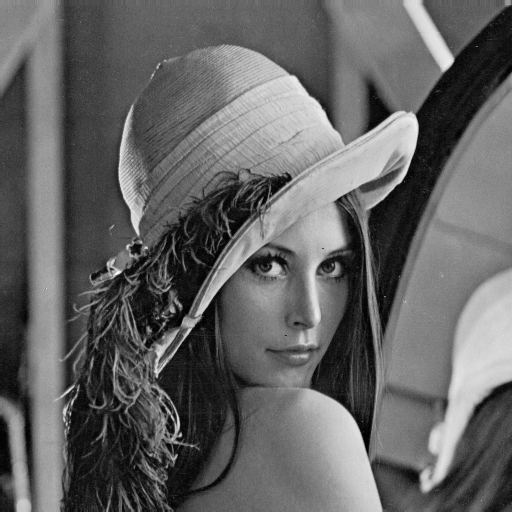

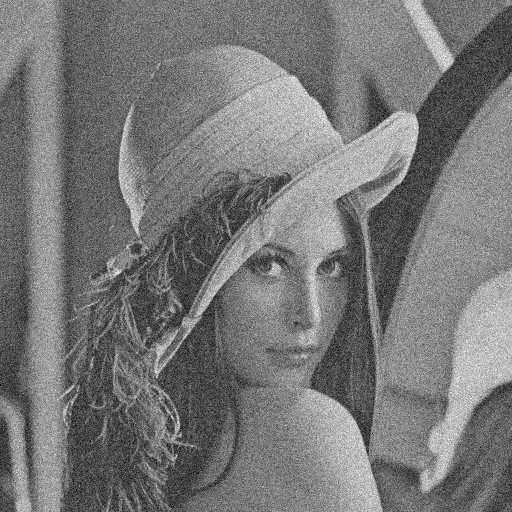

In [17]:
#%%

# voir l'image
viewimage_universelle(im,titre='ORIGINALE')
#degrader une image

imb=degrade_image(im,25)

# voir l'image bruitée
viewimage_universelle(imb,titre='BRUITEE')



<ipython-input-5-e3058ab021c2>:94: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numer=np.vectorize(np.complex)(np.zeros((sy,sx)))
<ipython-input-5-e3058ab021c2>:95: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  denom=np.vectorize(np.complex)(np.zeros((sy,sx)))


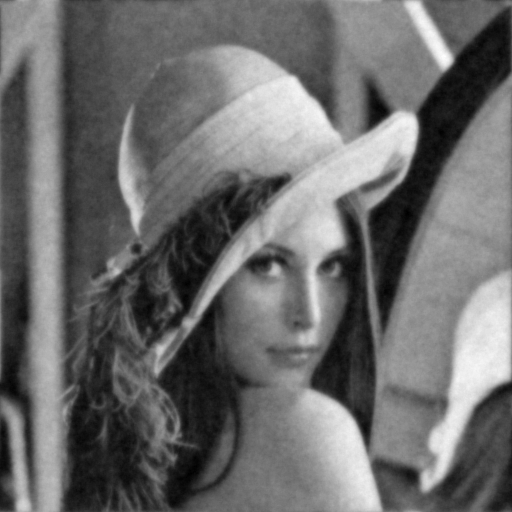

In [18]:
#%% restauration quadratique : exemple
lamb=5
restau=minimisation_quadratique(imb,lamb)
viewimage_universelle(restau,titre='RESTQUAD_LAMB='+str(lamb))



In [19]:
def difference(lambda_value, initial_u, vector_v):
    updated_u = minimisation_quadratique(vector_v, lambda_value).copy()
    return norm2(updated_u - vector_v) - norm2(initial_u - vector_v)

def binary_search_minimize(initial_u, vector_v, start, end, tolerance):
    lower_bound = start
    upper_bound = end
    while upper_bound - lower_bound > tolerance:
        middle = (lower_bound + upper_bound) / 2
        if difference(middle, initial_u, vector_v) > 0:
            upper_bound = middle
        else:
            lower_bound = middle
    return np.double((lower_bound + upper_bound) / 2)


In [20]:
print("Here is the value of Lambda that we have obtained "+str(binary_search_minimize(im,imb,0.1,10,0.001)))

<ipython-input-5-e3058ab021c2>:94: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numer=np.vectorize(np.complex)(np.zeros((sy,sx)))
<ipython-input-5-e3058ab021c2>:95: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  denom=np.vectorize(np.complex)(np.zeros((sy,sx)))


Here is the value of Lambda that we have obtained 3.201303100585937


In [21]:
lambdas = np.linspace(0.1, 1, 200)
norm_lamb_pairs = [(norm2(minimisation_quadratique(imb, lamb) - im), lamb) for lamb in lambdas]
min_norm_pair = min(norm_lamb_pairs, key=lambda pair: pair[0])
print("here is the value of Lambda "+str(min_norm_pair[1]))


<ipython-input-5-e3058ab021c2>:94: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numer=np.vectorize(np.complex)(np.zeros((sy,sx)))
<ipython-input-5-e3058ab021c2>:95: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  denom=np.vectorize(np.complex)(np.zeros((sy,sx)))


here is the value of Lambda 1.0


0.0
0.006


<ipython-input-5-e3058ab021c2>:94: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numer=np.vectorize(np.complex)(np.zeros((sy,sx)))
<ipython-input-5-e3058ab021c2>:95: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  denom=np.vectorize(np.complex)(np.zeros((sy,sx)))


0.012
0.018000000000000002
0.024
0.03
0.036000000000000004
0.042
0.048
0.054
0.06
0.066
0.07200000000000001
0.078
0.084
0.09
0.096
0.10200000000000001
0.108
0.114
0.12
0.126
0.132
0.138
0.14400000000000002
0.15
0.156
0.162
0.168
0.17400000000000002
0.18
0.186
0.192
0.198
0.20400000000000001
0.21
0.216
0.222
0.228
0.234
0.24
0.246


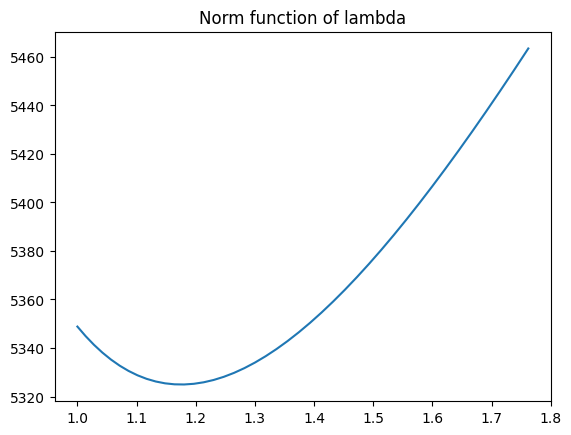

In [22]:
#%% COMPARAISON des methodes
# vous pouvez vous inspirer de ce qui suit pour trouver les meilleurs
# parametres de regularisation

errq=[]
errvt=[]
erreur=[]
vk=np.arange(0,0.25,0.006);
for k in vk:
    print (k)
    #restq=minimisation_quadratique(imb,10^(k));
    #errq.append[]=norm2(restq-myim);
    #restva=vartotale_Chambolle(imb,10**(k));
    restq=minimisation_quadratique(imb,10**(k))
    erreur.append(norm2(im-restq))
    #errvt.append(norm2(restva-myim));



plt.plot(10**vk,erreur);
plt.title("Norm function of lambda")
plt.show()



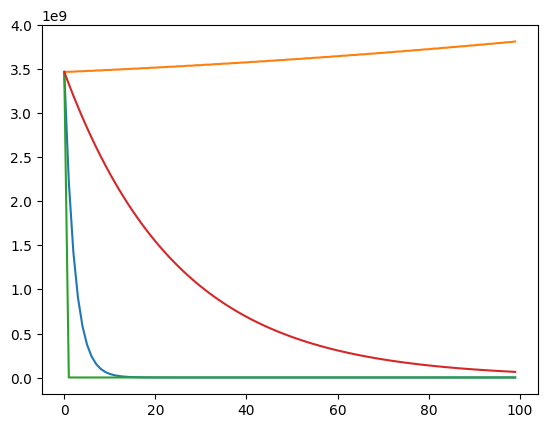

In [23]:
#%%
# we use the best Lambda that allows us to get the min error
u1,en1 =minimise_TV_gradient(imb,0.1,0.1,100)
u2,en2=minimise_TV_gradient(imb,0.1,1,100)
u3,en3=minimise_TV_gradient(imb,0.1,0.5,100)
u4,en4=minimise_TV_gradient(imb,0.1,0.01,100)
plt.plot(en1)
plt.plot(en2)
plt.plot(en3)
plt.plot(en4)


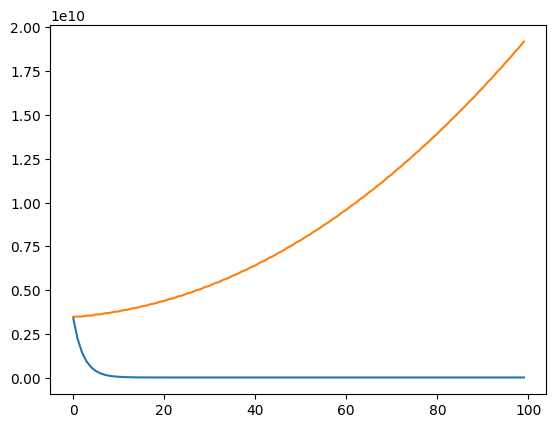

In [24]:
#%%
from time import time
myim=imread('lena.tif')
imb=degrade_image(myim,25)
(u,energ)=minimise_TV_gradient(imb,1,0.1,100)   # pas = 0.1
(u,energ2)=minimise_TV_gradient(imb,1,1,100)       # pas = 1
plt.plot(energ)
plt.plot(energ2)


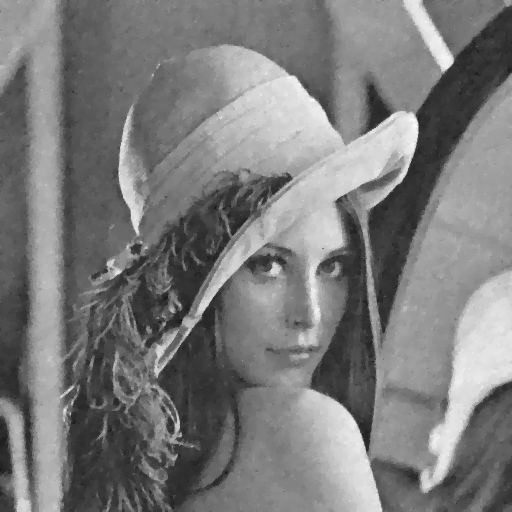

In [25]:
uch=vartotale_Chambolle(imb,40,itmax=100)
viewimage_universelle(uch)

In [26]:
t_grad = time()
(u_grad,energy) = minimise_TV_gradient(imb,40,0.01,1200)
dedicated_time_gradient = time()-t_grad
E2grad=E2_nonperiodique(u_grad,imb,40)

t_chambolle = time()
u_chambolle=vartotale_Chambolle(imb,40,itmax=30)
dedicated_time_chambolle=time()-t_chambolle
E2chamb=E2_nonperiodique(u_chambolle,imb,40)
ratio = E2chamb/E2grad

print("Gradient Descent Time : ",dedicated_time_gradient)

print("Chambolle Time : " ,dedicated_time_chambolle)

print("Energy Ratio : " ,ratio)


Gradient Descent Time :  18.107572555541992
Chambolle Time :  0.3148801326751709
Energy Ratio :  1.0022868272849434


<ipython-input-5-e3058ab021c2>:94: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numer=np.vectorize(np.complex)(np.zeros((sy,sx)))
<ipython-input-5-e3058ab021c2>:95: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  denom=np.vectorize(np.complex)(np.zeros((sy,sx)))


Best Lambda for quadratic regularization :  1.1220184543019658


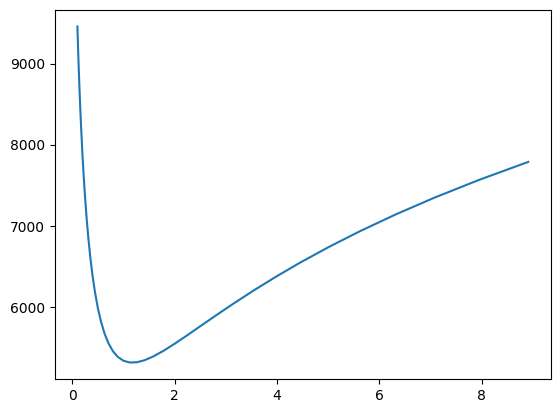

In [33]:
#%% COMPARAISON des methodes
# vous pouvez vous inspirer de ce qui suit pour trouver les meilleurs
# parametres de regularisation

errq=[]
vk_q=np.arange(-1,1,0.05)
for k in vk_q:
    restq=minimisation_quadratique(imb,10**(k))
    errq.append(norm2(restq-im))

plt.plot(10**vk_q,errq)
i_q=np.argmin(errq)
lambdas_q=10**vk_q
print("Best Lambda for quadratic regularization : ",lambdas_q[i_q])

Best Lambda for total variation :  39.81071705534978


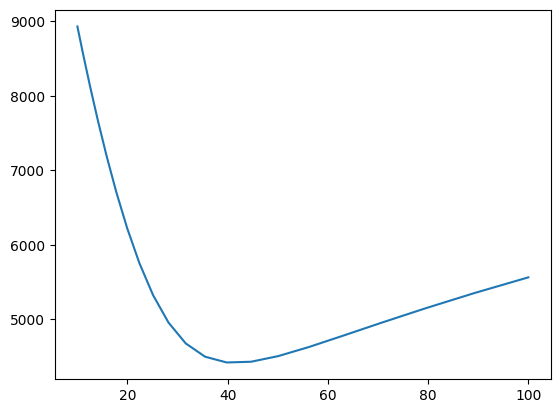

In [34]:
errvt=[]

vk_vt=np.arange(1,2.01,0.05)
for k in vk_vt:
    restva=vartotale_Chambolle(imb,10**(k))
    errvt.append(norm2(restva-im))
plt.plot(10**vk_vt,errvt)
i_vt=np.argmin(errvt)
lambdas_vt=10**vk_vt
print("Best Lambda for total variation : ",lambdas_vt[i_vt])

<ipython-input-5-e3058ab021c2>:94: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numer=np.vectorize(np.complex)(np.zeros((sy,sx)))
<ipython-input-5-e3058ab021c2>:95: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  denom=np.vectorize(np.complex)(np.zeros((sy,sx)))


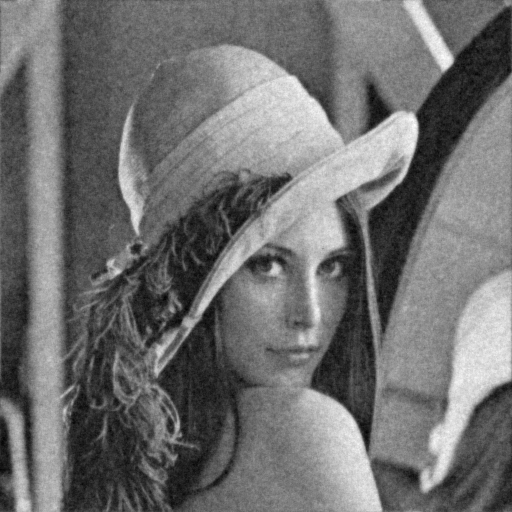

Error :  5311.767130471026 
Computation Time :  0.16677474975585938


In [35]:
from time import time

t1 = time()
uquad=minimisation_quadratique(imb,lambdas_q[i_q])
d1 = time()-t1
errquad=norm2(uquad-im)
viewimage_universelle(uquad,titre='Quadratic Regularization')

print("Error : ", errquad, "\nComputation Time : ",d1)

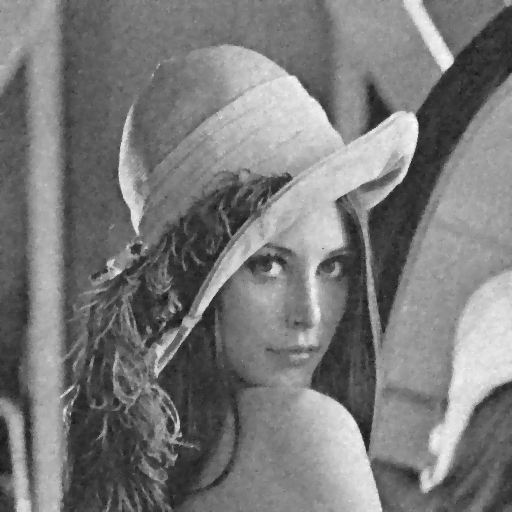

Error :  4470.400970717685 
Computation Time :  0.2979891300201416


In [36]:
t2=time()
uvt=vartotale_Chambolle(imb,lambdas_vt[i_vt],itmax=30)
d2=time()-t2

errvt=norm2(uvt-im)
viewimage_universelle(uvt,titre='Total Variation')

print("Error : ", errvt, "\nComputation Time : ",d2)